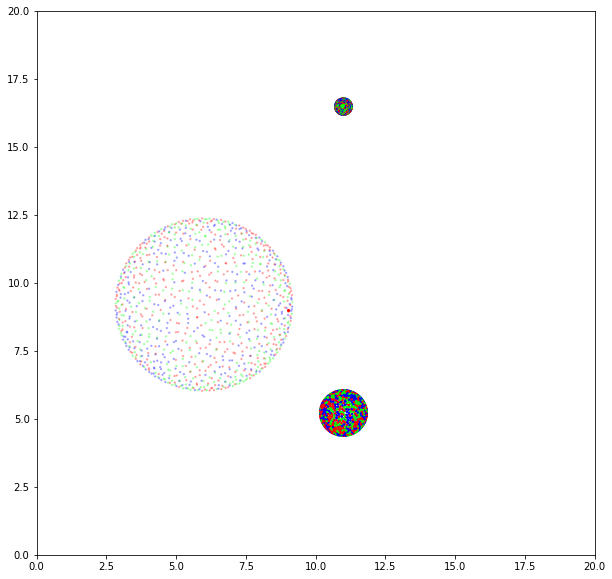

In [1]:
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes


class ExplosionAnimation:
    nb_points = 1000
    initial_speed = 0.3
    air_resistance = 1 / 75
    gravity = 1 / 300
    fade_speed = 0.15

    def __init__(self, center_x: float, center_y: float):
        self.center_x = center_x
        self.center_y = center_y
        self.direction_vectors = self.build_direction_vectors()
        self.nb_explosion_steps = int(np.floor(self.initial_speed / self.air_resistance))
        self.fadeout_start = self.nb_explosion_steps - 10
        self.colors = self.build_colors_vectors()

    def build_direction_vectors(self):
        golden_angle = 2.39996322972865332
        direction_latitudes = np.arcsin(-1 + 2 * np.arange(self.nb_points) / (self.nb_points + 1))
        direction_longitudes = np.arange(self.nb_points) * golden_angle
        direction_vectors = np.stack([
            np.cos(direction_longitudes) * np.cos(direction_latitudes),  # x
            np.sin(direction_longitudes) * np.cos(direction_latitudes),  # y
            np.sin(direction_latitudes)  # z
        ])
        return direction_vectors

    def build_colors_vectors(self):
        return np.take(
            np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float),
            np.random.randint(3, size=self.nb_points),
            axis=0
        )

    def plot(self, frame_idx: int):
        explosion_step_idx = min(frame_idx, self.nb_explosion_steps)
        alpha = 1 - np.clip((frame_idx - self.fadeout_start) * self.fade_speed, 0, 1)

        initial_x = np.full(self.nb_points, self.center_x)
        x_speed_vector = np.full(self.nb_points, self.initial_speed) * self.direction_vectors[0]
        x_acceleration_vector = np.full(self.nb_points, -self.air_resistance) * self.direction_vectors[0]
        x = initial_x + x_speed_vector * explosion_step_idx + 1 / 2 * x_acceleration_vector * explosion_step_idx ** 2

        initial_y = np.full(self.nb_points, self.center_y)
        y_speed_vector = np.full(self.nb_points, self.initial_speed) * self.direction_vectors[1]
        y_air_resistance_acceleration = (np.full(self.nb_points, -self.air_resistance) * self.direction_vectors[1])
        y_explosion_motion = (
                initial_y +
                y_speed_vector * explosion_step_idx +
                1 / 2 * y_air_resistance_acceleration * explosion_step_idx ** 2
        )
        y_gravity_acceleration = np.full(self.nb_points, -self.gravity)
        y = y_explosion_motion + 1 / 2 * y_gravity_acceleration * frame_idx ** 2

        plt.scatter(x, y, s=2, c=self.colors, alpha=alpha)

        if alpha > 0:
            return False  # animation continues
        else:
            return True  # animation is over


class FireworkAnimation:
    gravity = 1 / 25

    def __init__(self, x: float, launch_speed: float):
        self.x = x
        self.nb_rocket_steps = int(np.floor(launch_speed / self.gravity))
        self.launch_speed = launch_speed
        self.explosion_animation = ExplosionAnimation(
            center_x=x,
            center_y=self.compute_rocket_height(self.nb_rocket_steps)
        )

    def plot(self, frame_idx: int):
        if frame_idx <= self.nb_rocket_steps:
            plt.scatter(self.x, self.compute_rocket_height(frame_idx), s=4, c='r')
            return False
        else:
            return self.explosion_animation.plot(frame_idx - self.nb_rocket_steps)

    def compute_rocket_height(self, frame_idx: int):
        acceleration = -self.gravity
        y = frame_idx * self.launch_speed + 1 / 2 * acceleration * frame_idx ** 2
        return y


class AnimationFunction:
    def __init__(self, xlim: Tuple[int, int], ylim: Tuple[int, int], launch_every: int):
        self.xlim = xlim
        self.ylim = ylim
        self.launch_every = launch_every
        self.animations_list: List[Tuple[FireworkAnimation, int]] = list()

    def new_animation(self):
        return FireworkAnimation(
            x=np.random.randint(self.xlim[0] + 3, self.xlim[1] - 3),
            launch_speed=np.random.random() * 0.6 + 0.6
        )

    def __call__(self, frame_idx: int, ax: Axes):
        ax.cla()
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        if frame_idx % self.launch_every == 0:
            self.animations_list.append((self.new_animation(), frame_idx))

        finished_animations = list()
        for animation_idx, (animation, start_idx) in enumerate(self.animations_list):
            is_over = animation.plot(frame_idx - start_idx)
            if is_over:
                finished_animations.append(animation_idx)

        for animation_idx in reversed(finished_animations):
            del self.animations_list[animation_idx]


def main():
    animation_function = AnimationFunction((0, 20), (0, 20), launch_every=10)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    animation = FuncAnimation(
        fig=fig,
        func=animation_function,
        init_func=lambda: None,
        frames=30 * 10,
        interval=1000 / 30,
        fargs=(ax,)
    )
    animation.save('animation.mp4')


if __name__ == '__main__':
    main()